In [67]:
import pandas as pd
import numpy as np

# Features Faloperas

- shifts de produccion por finca, variedad, modo
- shifts de produccion por finca y variedad
- shifts de produccion por finca
- shift de produccion promedio y std por hectarea por variedad y modo

In [3]:
path = '../../data/processed/wine_pro.csv'

wine_data = pd.read_csv(path)

In [4]:
wine_data.head()

,campana,id_finca,id_zona,id_estacion,altitud,variedad,modo,tipo,color,superficie,produccion,sup_tot_camp_finca,superficie_total,n_var_camp_finca
0,14,76953,515,4,660.000000,26,2,0,1,-1.0,22215.0,-1.0,-1.0,1
1,14,84318,515,4,660.000000,26,2,0,1,-1.0,22215.0,-1.0,-1.0,1
2,14,85579,340,4,520.000000,32,2,0,1,-1.0,20978.0,-1.0,-1.0,1
3,14,69671,340,4,520.000000,32,2,0,1,-1.0,40722.0,-1.0,-1.0,1
4,14,14001,852,14,659.097938,81,1,0,1,-1.0,14126.0,-1.0,-1.0,1


In [50]:
# top_10_var = 
wine_data['variedad'].value_counts().index[:10]
#  .index[:10].values


Int64Index([59, 17, 32, 52, 81, 68, 87, 40, 15, 9], dtype='int64')

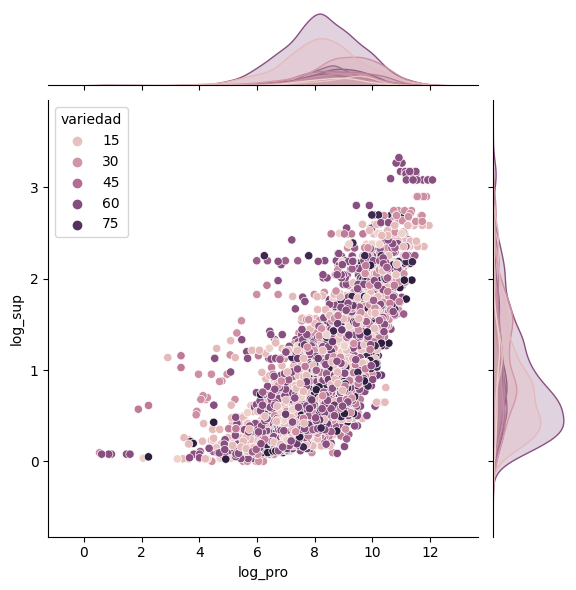

In [44]:
import seaborn as sns

top_10_var = wine_data['variedad'].value_counts().index[:10].values

sns.jointplot(
    data=wine_data.assign(
        prod_he=lambda df: df['produccion']/df['superficie']
        ).query("prod_he>0  & variedad in @top_10_var").assign(
        log_prod_he=lambda df: np.log(1+df['prod_he']),
        log_sup = lambda df: np.log(1+df['superficie']),
        log_pro = lambda df: np.log(1+df['produccion'])
    ),
    x='log_pro',
    y='log_sup',
    hue='variedad'
)


<AxesSubplot: xlabel='variedad', ylabel='prod_he'>

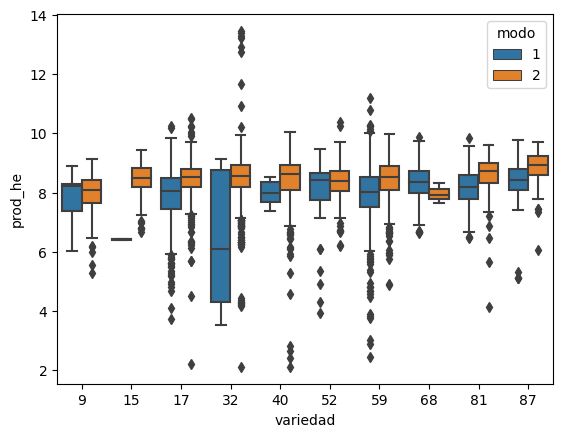

In [34]:
top_10_var = wine_data['variedad'].value_counts().index[:10].values

sns.boxplot(
    data=wine_data.assign(prod_he=lambda df: df['produccion']/df['superficie']).query(
        "prod_he>0 & variedad in @top_10_var").assign(prod_he=lambda df: np.log(1+df['prod_he'])),
    y='prod_he',
    x='variedad',
    hue='modo'
)


In [66]:

wine_data.groupby(['id_finca','campana'])[['produccion']].sum().assign(
    produccion = lambda df: df['produccion'].apply(lambda x: x if x > 0 else np.nan)
).unstack(1)


produccion                                                         \
campana          14         15         16         17         18         19   
id_finca                                                                     
200        1900.000    778.104   1636.200    829.008    607.212    392.688   
439        2215.200   3208.400   6354.400        NaN        NaN        NaN   
447        1824.700   3242.106   2524.284   1336.986        NaN        NaN   
523        2290.400        NaN        NaN   3732.000   2836.074   1225.824   
528       22780.000        NaN        NaN        NaN        NaN        NaN   
...             ...        ...        ...        ...        ...        ...   
99146           NaN   6480.000   4080.000   6060.000   3700.000   3380.000   
99282      6630.663   8000.800   9230.000   5840.000   9070.000   7380.000   
99377           NaN   2280.000   1550.000        NaN   2160.000   1840.000   
99693     16856.590  14480.844  15931.125  20130.201  17597.034  18405.387   
99793           NaN        NaN        NaN        NaN        NaN        NaN   

                                    
campana          20         21  22  
id_finca                            
200         545.400        NaN NaN  
439             NaN   1901.402 NaN  
447        2828.540   2037.340 NaN  
523         947.844    745.122 NaN  
528             NaN        NaN NaN  
...             ...        ...  ..  
99146      3300.000   4730.000 NaN  
99282      6710.000   8460.000 NaN  
99377      2300.000   2460.000 NaN  
99693     26876.300  35418.700 NaN  
99793           NaN        NaN NaN  

[1231 rows x 9 columns]

In [6]:
# shifts

wine_data['prod_shift_1'] = wine_data.groupby(['id_finca','variedad','modo'])['produccion'].shift(1).fillna(-1)
wine_data['prod_shift_2'] = wine_data.groupby(['id_finca','variedad','modo'])['produccion'].shift(2).fillna(-1)


prod_by_finca_var = wine_data.groupby(['campana','id_finca','variedad'])['produccion'].sum().reset_index()
prod_by_finca_var['prod_var_shift_1'] = prod_by_finca_var.groupby(['id_finca','variedad'])['produccion'].shift(1).fillna(-1)
prod_by_finca_var['prod_var_shift_2'] = prod_by_finca_var.groupby(['id_finca','variedad'])['produccion'].shift(2).fillna(-1)


prod_by_finca = wine_data.groupby(['campana','id_finca'])['produccion'].sum().reset_index()
prod_by_finca['prod_finca_shift_1'] = prod_by_finca.groupby(['id_finca'])['produccion'].shift(1).fillna(-1)
prod_by_finca['prod_finca_shift_2'] = prod_by_finca.groupby(['id_finca'])['produccion'].shift(2).fillna(-1)

wine_data = wine_data.merge(
    prod_by_finca_var[['campana','id_finca','variedad','prod_var_shift_1','prod_var_shift_2']],
    left_on=['campana','id_finca','variedad'],
    right_on=['campana','id_finca','variedad'],
).merge(
    prod_by_finca[['campana','id_finca','prod_finca_shift_1','prod_finca_shift_2']],
    left_on=['campana','id_finca'],
    right_on=['campana','id_finca'],    
)

In [7]:
wine_data = wine_data.merge(
    prod_by_finca_var[['campana','id_finca','variedad','prod_var_shift_1','prod_var_shift_2']],
    left_on=['campana','id_finca','variedad'],
    right_on=['campana','id_finca','variedad'],
).merge(
    prod_by_finca[['campana','id_finca','prod_finca_shift_1','prod_finca_shift_2']],
    left_on=['campana','id_finca'],
    right_on=['campana','id_finca'],    
)

In [8]:
wine_data[wine_data['id_finca']==58769]

,campana,id_finca,id_zona,id_estacion,altitud,variedad,modo,tipo,color,superficie,produccion,sup_tot_camp_finca,superficie_total,n_var_camp_finca,prod_shift_1,prod_shift_2,prod_var_shift_1,prod_var_shift_2,prod_finca_shift_1,prod_finca_shift_2
1145,14,58769,239,6,700.0,32,2,0,1,4.25,42350.0,4.25,7.003333,1,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
2261,15,58769,239,6,700.0,32,2,0,1,4.25,30380.0,4.25,7.003333,1,42350.0,-1.0,42350.0,-1.0,42350.0,-1.0
3339,16,58769,239,6,700.0,32,2,0,1,4.25,41940.0,4.25,7.003333,1,30380.0,42350.0,30380.0,42350.0,30380.0,42350.0
4356,17,58769,239,6,700.0,32,2,0,1,4.25,33600.0,8.38,7.003333,2,41940.0,30380.0,41940.0,30380.0,41940.0,30380.0
4357,17,58769,239,6,700.0,59,2,0,1,4.13,35940.0,8.38,7.003333,2,-1.0,-1.0,-1.0,-1.0,41940.0,30380.0
5417,18,58769,239,6,700.0,32,2,0,1,4.25,54900.0,8.38,7.003333,2,33600.0,41940.0,33600.0,41940.0,69540.0,41940.0
5418,18,58769,239,6,700.0,59,2,0,1,4.13,34800.0,8.38,7.003333,2,35940.0,-1.0,35940.0,-1.0,69540.0,41940.0
6472,19,58769,239,6,700.0,32,2,0,1,4.25,30840.0,8.38,7.003333,2,54900.0,33600.0,54900.0,33600.0,89700.0,69540.0
6473,19,58769,239,6,700.0,59,2,0,1,4.13,24090.0,8.38,7.003333,2,34800.0,35940.0,34800.0,35940.0,89700.0,69540.0
7478,20,58769,239,6,700.0,32,2,0,1,4.25,38480.0,8.41,7.003333,2,30840.0,54900.0,30840.0,54900.0,54930.0,89700.0


In [9]:
prod_he_var = (
    wine_data
    [['campana','variedad','modo','superficie','produccion']]
    .assign(prod_he_var_modo = lambda df: df['produccion']/df['superficie'])
    .query('prod_he_var_modo>0')
    [['campana','variedad','modo','prod_he_var_modo']]
    .groupby(["campana",'variedad','modo'])
    .agg(
        prod_he_var_modo_mean=('prod_he_var_modo', 'mean'), 
        prod_he_var_modo_std=('prod_he_var_modo', 'std')
    )
    .fillna(0).reset_index()
)

In [10]:
prod_he_var = pd.concat([
    prod_he_var[['campana', 'variedad', 'modo']],
    (prod_he_var.groupby(['variedad','modo'])
    [['prod_he_var_modo_mean','prod_he_var_modo_std']]
    .shift(1).fillna(-1)
    .rename(columns={
        'prod_he_var_modo_mean':"prod_he_var_modo_mean_shift_1",
        'prod_he_var_modo_std':"prod_he_var_modo_std_shift_1"
    })
)],axis=1)

In [13]:
prod_he_var


,campana,variedad,modo,prod_he_var_modo_mean_shift_1,prod_he_var_modo_std_shift_1
0,14,8,2,-1.000000,-1.000000
1,14,9,1,-1.000000,-1.000000
2,14,9,2,-1.000000,-1.000000
3,14,15,2,-1.000000,-1.000000
4,14,17,1,-1.000000,-1.000000
...,...,...,...,...,...
251,21,84,2,7208.998546,2092.157560
252,21,87,1,4038.519641,2626.642238
253,21,87,2,7248.183443,3498.689763
254,21,92,1,6048.528778,4640.468375


In [11]:
# mean_prod_he_var
wine_data = wine_data.merge(
    prod_he_var[['campana','variedad','modo','prod_he_var_modo_mean_shift_1','prod_he_var_modo_std_shift_1']],
    left_on=['campana','variedad','modo'],
    right_on=['campana','variedad','modo'],
)

In [19]:
wine_data[wine_data['modo']==1][['altitud','produccion']].corr()
# wine_data[wine_data['modo']==2][['altitud','produccion']].corr()

# wine_data[['altitud','produccion']].corr()
# wine_data[wine_data['variedad']==26][['altitud','produccion']].corr()

,altitud,produccion
altitud,1.000000,-0.114669
produccion,-0.114669,1.000000


In [12]:
wine_data

,campana,id_finca,id_zona,id_estacion,altitud,variedad,modo,tipo,color,superficie,...,superficie_total,n_var_camp_finca,prod_shift_1,prod_shift_2,prod_var_shift_1,prod_var_shift_2,prod_finca_shift_1,prod_finca_shift_2,prod_he_var_modo_mean_shift_1,prod_he_var_modo_std_shift_1
0,14,76953,515,4,660.000000,26,2,0,1,-1.0000,...,-1.000000,1,-1.0,-1.0,-1.0,-1.0,-1.000,-1.000,-1.000000,-1.000000
1,14,84318,515,4,660.000000,26,2,0,1,-1.0000,...,-1.000000,1,-1.0,-1.0,-1.0,-1.0,-1.000,-1.000,-1.000000,-1.000000
2,14,89440,506,7,610.000000,26,2,0,1,4.5000,...,6.180000,1,-1.0,-1.0,-1.0,-1.0,-1.000,-1.000,-1.000000,-1.000000
3,14,85548,803,5,635.000000,26,2,0,1,3.6318,...,6.500689,4,-1.0,-1.0,-1.0,-1.0,-1.000,-1.000,-1.000000,-1.000000
4,14,85579,340,4,520.000000,32,2,0,1,-1.0000,...,-1.000000,1,-1.0,-1.0,-1.0,-1.0,-1.000,-1.000,-1.000000,-1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8477,21,47829,871,19,580.000000,92,1,0,0,1.3464,...,4.014933,2,12930.0,13260.0,12930.0,13260.0,20546.000,23102.000,6048.528778,4640.468375
8478,21,17321,449,15,625.000000,9,1,0,0,0.6409,...,0.766900,2,2390.0,2080.0,2390.0,2080.0,2772.500,2612.500,2489.565455,1753.010278
8479,21,83458,292,3,633.410042,10,2,0,1,1.8125,...,2.829200,2,7760.0,9030.0,7760.0,9030.0,10283.315,16334.630,4281.379310,0.000000
8480,21,59516,74,19,560.000000,65,1,0,1,1.1399,...,1.690000,2,5170.0,3220.0,5170.0,3220.0,8152.824,5819.092,4535.485569,0.000000


In [85]:
wine_data.to_csv('../../data/final/wine_final.csv',index=False)

# Meteo y Eto

In [68]:
path = '../../data/processed/eto_pro.csv'
eto_data = pd.read_csv(path)

In [69]:
# eto_data.filter(like="Precip")
eto_data.columns

Index(['year', 'ID_ESTACION', 'GustLocalDayAvgMonth1', 'GustLocalDayAvgMonth2',
       'GustLocalDayAvgMonth3', 'GustLocalDayAvgMonth4',
       'GustLocalDayAvgMonth5', 'GustLocalDayAvgMonth6',
       'MSLPLocalDayAvgMonth1', 'MSLPLocalDayAvgMonth2',
       'MSLPLocalDayAvgMonth3', 'MSLPLocalDayAvgMonth4',
       'MSLPLocalDayAvgMonth5', 'MSLPLocalDayAvgMonth6',
       'RelativeHumidityLocalDayAvgMonth1',
       'RelativeHumidityLocalDayAvgMonth2',
       'RelativeHumidityLocalDayAvgMonth3',
       'RelativeHumidityLocalDayAvgMonth4',
       'RelativeHumidityLocalDayAvgMonth5',
       'RelativeHumidityLocalDayAvgMonth6', 'UVIndexLocalDayAvgMonth1',
       'UVIndexLocalDayAvgMonth2', 'UVIndexLocalDayAvgMonth3',
       'UVIndexLocalDayAvgMonth4', 'UVIndexLocalDayAvgMonth5',
       'UVIndexLocalDayAvgMonth6', 'VisibilityLocalDayAvgMonth1',
       'VisibilityLocalDayAvgMonth2', 'VisibilityLocalDayAvgMonth3',
       'VisibilityLocalDayAvgMonth4', 'VisibilityLocalDayAvgMonth5',
       'Visib

In [70]:
snow_cols = [
    [f"TotalSnowAmountLocalDaytimeMonth{i}", f"TotalSnowAmountLocalNighttimeMonth{i}"]
    for i in range(1, 7)
]

for i, c in enumerate(snow_cols):
    eto_data[f'TotalSnowMonth{i+1}'] = eto_data[list(c)].sum(axis=1)

In [71]:
eto_data
snow_cols = [
    [f"TotalPrecipAmountLocalDaytimeMonth{i}",f"TotalPrecipAmountLocalNighttimeMonth{i}"]
    for i in range(1, 7)
]

for i, c in enumerate(snow_cols):
    eto_data[f'TotalPrecipMonth{i+1}'] = eto_data[list(c)].sum(axis=1)


array([[<AxesSubplot: title={'center': 'TotalPrecipMonth1'}>,
        <AxesSubplot: title={'center': 'TotalPrecipMonth2'}>],
       [<AxesSubplot: title={'center': 'TotalPrecipMonth3'}>,
        <AxesSubplot: title={'center': 'TotalPrecipMonth4'}>],
       [<AxesSubplot: title={'center': 'TotalPrecipMonth5'}>,
        <AxesSubplot: title={'center': 'TotalPrecipMonth6'}>]],
      dtype=object)

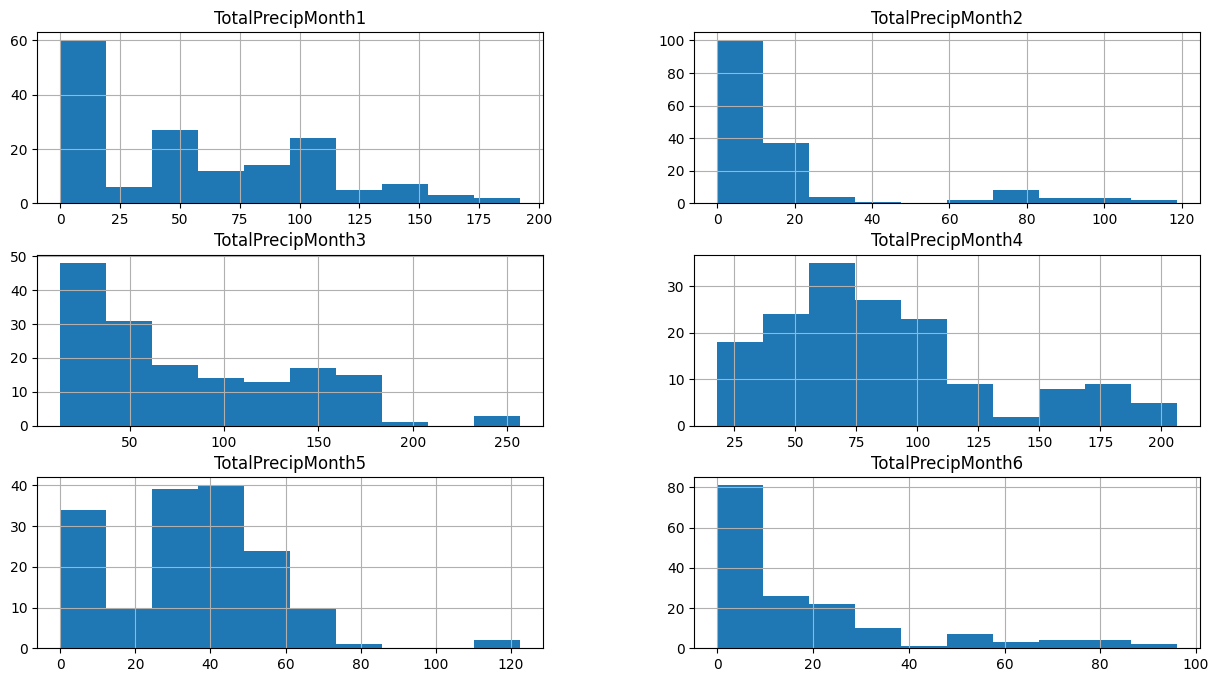

In [72]:
eto_data.filter(like='TotalPrecipMonth').hist(figsize=(15,8))

array([[<AxesSubplot: title={'center': 'GustLocalDayAvgMonth1'}>,
        <AxesSubplot: title={'center': 'GustLocalDayAvgMonth2'}>],
       [<AxesSubplot: title={'center': 'GustLocalDayAvgMonth3'}>,
        <AxesSubplot: title={'center': 'GustLocalDayAvgMonth4'}>],
       [<AxesSubplot: title={'center': 'GustLocalDayAvgMonth5'}>,
        <AxesSubplot: title={'center': 'GustLocalDayAvgMonth6'}>]],
      dtype=object)

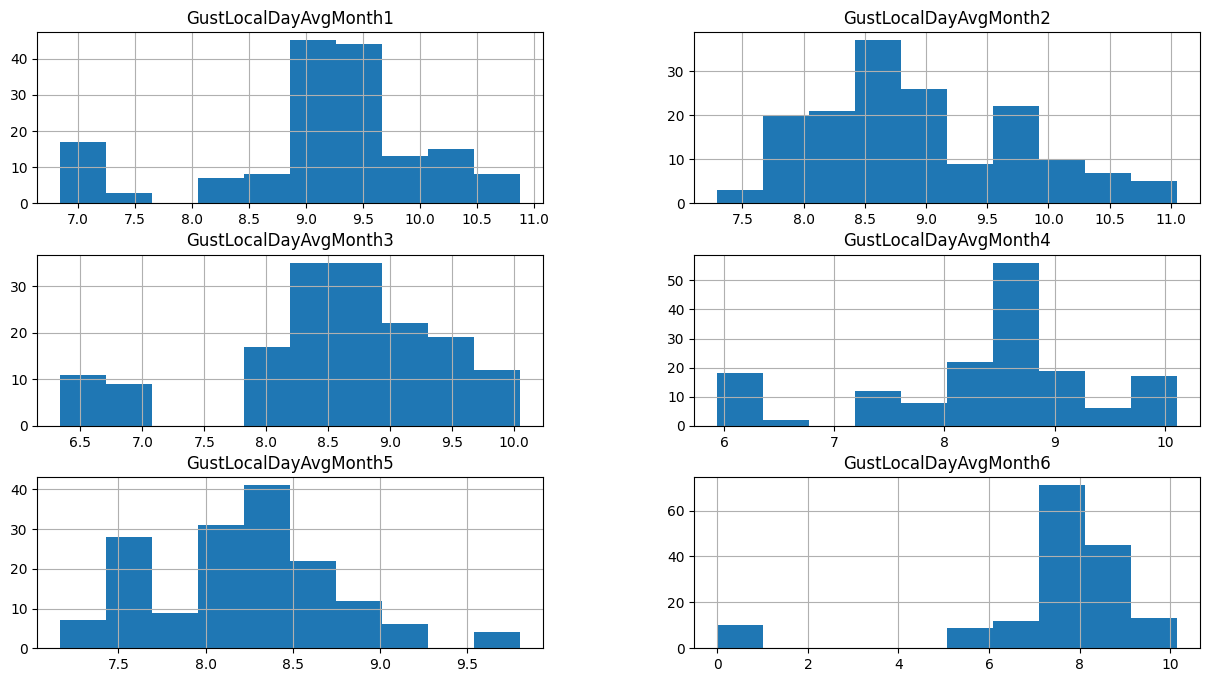

In [73]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

eto_gust = eto_data.filter(like="Gust")
eto_gust.hist(figsize=(15,8))

In [74]:
# maximo de cada mes
eto_data["GustDaySumMonth"] = eto_data.filter(like="GustLocal").sum(axis=1)
eto_data["GustDaySumMonth"] = eto_data.filter(like="GustLocal").max(axis=1)


In [75]:
def pca_analysis(data):
    n_comps = data.shape[1]
    scaler = StandardScaler()
    pca = PCA(n_components=n_comps)
    data_tr = scaler.fit_transform(data)
    pca.fit(data_tr)
    pca.explained_variance_ratio_
    pd.DataFrame(
        np.cumsum(pca.explained_variance_ratio_),
        index=range(1, n_comps+1),
        columns=['explained_variance']
    ).plot(figsize=(7,4))
    return pca

array([[<AxesSubplot: title={'center': 'MSLPLocalDayAvgMonth1'}>,
        <AxesSubplot: title={'center': 'MSLPLocalDayAvgMonth2'}>],
       [<AxesSubplot: title={'center': 'MSLPLocalDayAvgMonth3'}>,
        <AxesSubplot: title={'center': 'MSLPLocalDayAvgMonth4'}>],
       [<AxesSubplot: title={'center': 'MSLPLocalDayAvgMonth5'}>,
        <AxesSubplot: title={'center': 'MSLPLocalDayAvgMonth6'}>]],
      dtype=object)

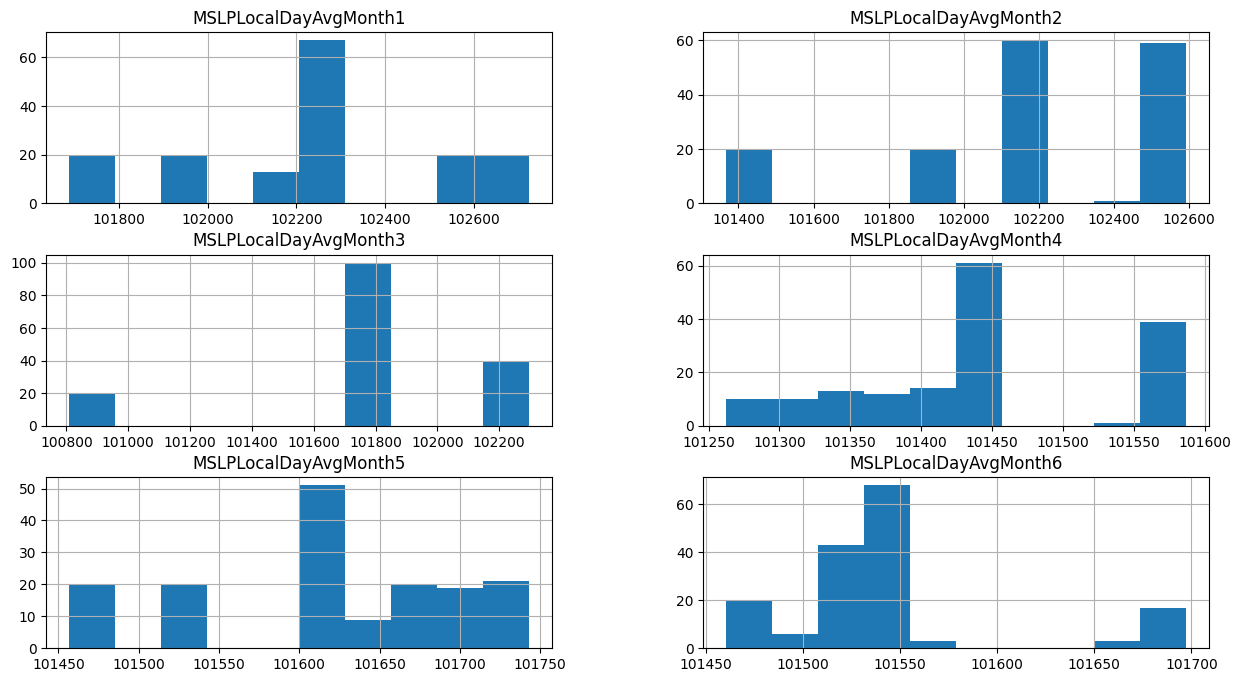

In [76]:
eto_data.filter(like='MSLP').hist(figsize=(15,8))

array([[<AxesSubplot: title={'center': 'UVIndexLocalDayAvgMonth1'}>,
        <AxesSubplot: title={'center': 'UVIndexLocalDayAvgMonth2'}>],
       [<AxesSubplot: title={'center': 'UVIndexLocalDayAvgMonth3'}>,
        <AxesSubplot: title={'center': 'UVIndexLocalDayAvgMonth4'}>],
       [<AxesSubplot: title={'center': 'UVIndexLocalDayAvgMonth5'}>,
        <AxesSubplot: title={'center': 'UVIndexLocalDayAvgMonth6'}>]],
      dtype=object)

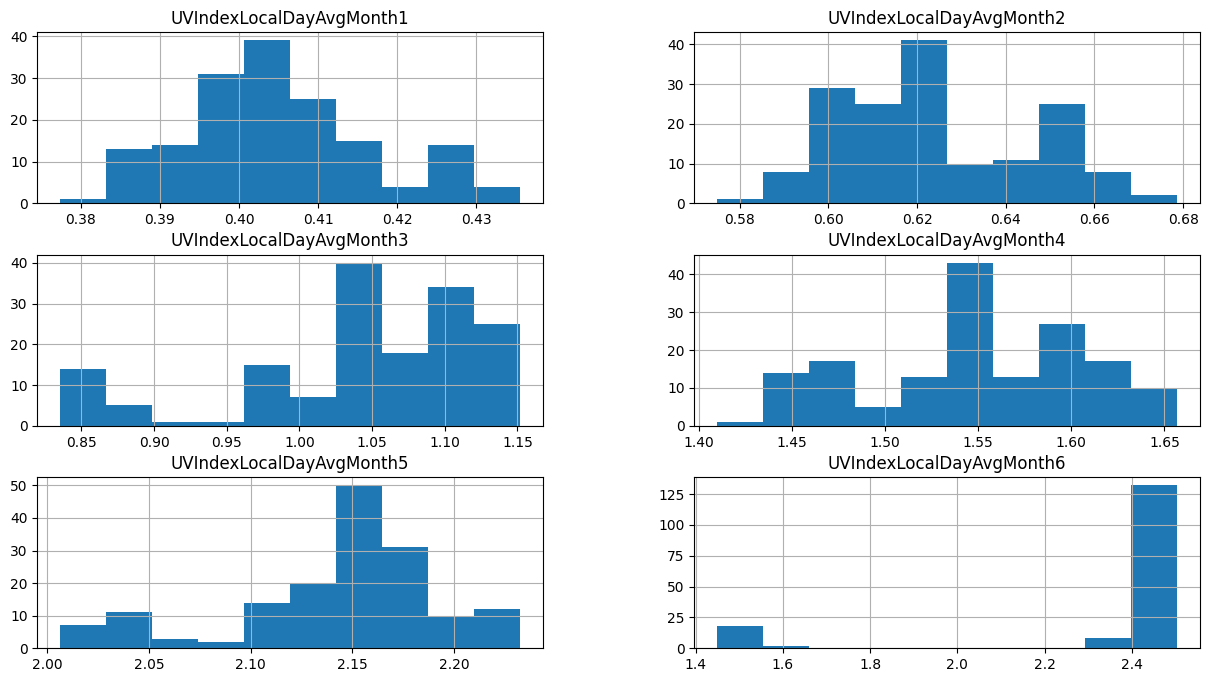

In [77]:
eto_data.columns
eto_data.filter(like='UVIndex').hist(figsize=(15,8))
# max of summer months

In [78]:
uv_cols = eto_data.filter(like='UVIndexLocal').columns.to_list()

summer_uv_cols = [c for c in uv_cols if int(c[-1]) in [1,2,3]]
winter_uv_cols = [c for c in uv_cols if int(c[-1]) in [4,5,6]]

eto_data['UVIndexSummerSum'] = eto_data[summer_uv_cols].sum(axis=1)
eto_data['UVIndexWinterSum'] = eto_data[winter_uv_cols].sum(axis=1)
eto_data['UVIndexSummerAvg'] = eto_data[summer_uv_cols].mean(axis=1)
eto_data['UVIndexWinterAvg'] = eto_data[winter_uv_cols].mean(axis=1)


PCA(n_components=6)

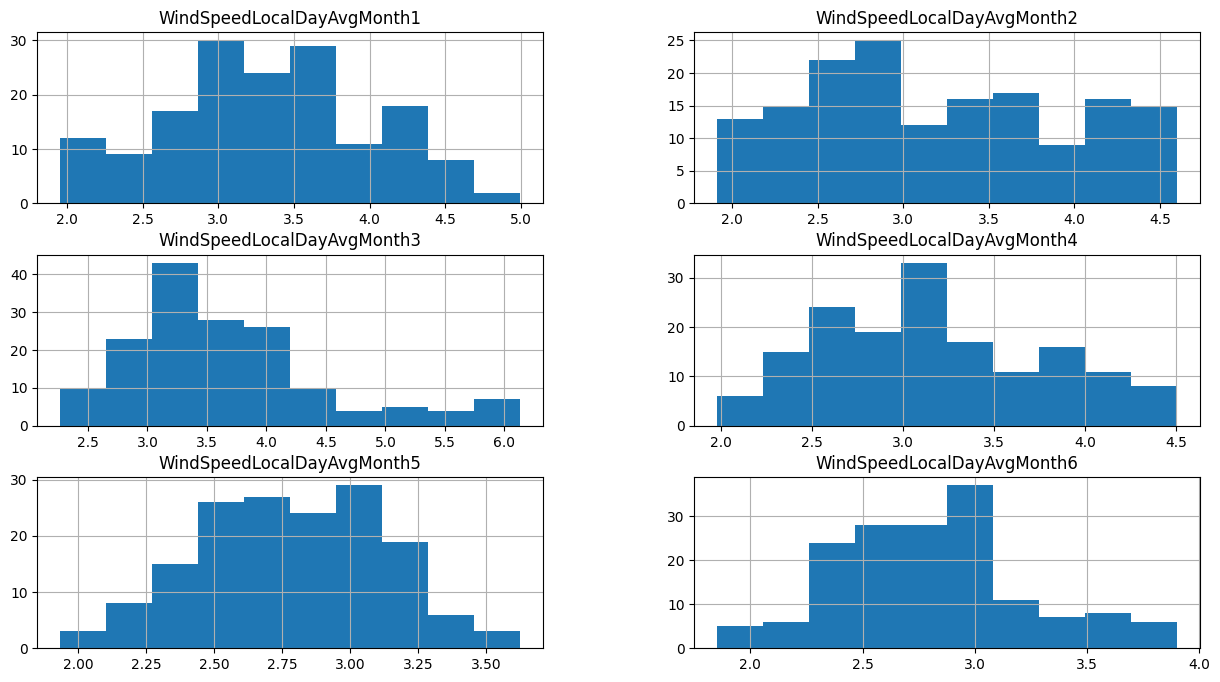

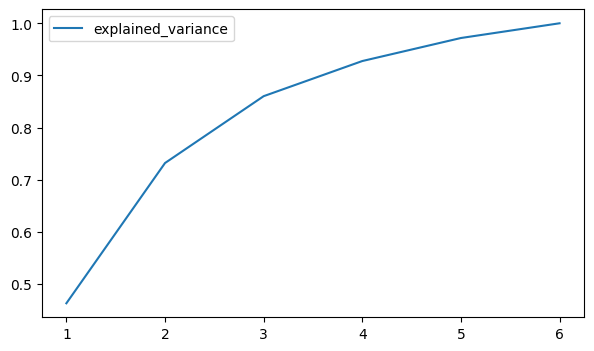

In [79]:
eto_data.filter(like='WindSpeedLocal').hist(figsize=(15,8))

pca_analysis(eto_data.filter(like='WindSpeedLocal'))


In [80]:
eto_data['WindSpeedSum'] = eto_data.filter(like='WindSpeedLocal').sum(axis=1)


In [84]:
eto_data.to_csv('../../data/final/eto_final.csv',index=False)


In [83]:
eto_data.filter(like='Temp')


,TemperatureLocalAfternoonAvgMonth1,TemperatureLocalAfternoonAvgMonth2,TemperatureLocalAfternoonAvgMonth3,TemperatureLocalAfternoonAvgMonth4,TemperatureLocalAfternoonAvgMonth5,TemperatureLocalAfternoonAvgMonth6,TemperatureLocalOvernightAvgMonth1,TemperatureLocalOvernightAvgMonth2,TemperatureLocalOvernightAvgMonth3,TemperatureLocalOvernightAvgMonth4,TemperatureLocalOvernightAvgMonth5,TemperatureLocalOvernightAvgMonth6,TemperatureLocalDayAvgMonth1,TemperatureLocalDayAvgMonth2,TemperatureLocalDayAvgMonth3,TemperatureLocalDayAvgMonth4,TemperatureLocalDayAvgMonth5,TemperatureLocalDayAvgMonth6
0,285.202765,287.347467,287.953917,289.938095,295.820276,308.000000,279.000000,280.159395,281.133641,283.176190,286.700461,292.500000,281.364055,283.184201,284.161290,286.142857,290.976959,301.000000
1,283.078341,285.756685,286.437788,288.861905,295.129032,307.500000,276.364055,277.805419,278.963134,281.252381,285.004608,293.500000,278.898618,281.084975,282.235023,284.600000,289.728111,302.000000
2,285.730876,288.310697,289.029032,291.163810,296.843318,307.850000,277.949309,279.451689,280.666359,282.914762,286.223963,292.600000,280.938249,283.125475,284.340092,286.565238,291.297235,301.650000
3,284.267281,286.653765,287.285714,289.485714,295.631336,308.000000,277.672811,279.014426,280.096774,282.252381,285.843318,293.000000,280.156682,282.134940,283.239631,285.423810,290.382488,302.000000
4,284.476498,287.066467,287.752995,290.093810,296.198618,308.000000,277.371889,278.685468,279.921659,282.174762,285.752995,292.550000,280.055760,282.131967,283.352995,285.643333,290.639631,302.150000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
155,284.483871,287.428571,284.032258,287.833333,297.354839,303.766667,275.645161,278.571429,280.129032,281.600000,286.419355,290.900000,279.193548,282.250000,281.774194,284.333333,291.483871,297.000000
156,284.838710,287.750000,284.645161,288.200000,297.677419,304.033333,275.354839,278.464286,280.516129,281.800000,286.580645,291.166667,279.258065,282.392857,282.225806,284.566667,291.870968,297.200000
157,283.741935,286.642857,283.354839,286.966667,296.774194,303.333333,274.774194,277.928571,279.548387,280.833333,286.064516,290.500000,278.354839,281.607143,281.032258,283.433333,291.193548,296.666667
158,284.951613,287.817857,284.458065,288.173333,297.364516,303.810000,275.735484,279.053571,280.474194,281.853333,286.654839,291.126667,279.474194,282.639286,282.167742,284.613333,291.690323,297.143333
